In [1]:
run = 'autoencoder_01'

In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

gpu_list = get_available_gpus()

gpu = str(gpu_list[-1])
[gpu_list, gpu]

[[u'/gpu:0', u'/gpu:1'], '/gpu:1']

##### 00. Load Packages

In [3]:
%pylab inline


import seaborn as sns
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [4]:
import tensorflow as tf
import keras

import glob as glob
import cv2 as cv2
from tqdm import tqdm

Using TensorFlow backend.


In [5]:
from keras import backend as K
from keras.models import Input, Sequential, load_model, Model
from keras.layers import Dropout, Activation
from keras.layers import Lambda, Conv2D, Dense, MaxPooling2D,UpSampling2D

from keras.layers.normalization import BatchNormalization

In [6]:
train_files = glob.glob('../01.data/extracted/images_training_rev1/*.jpg')
test_files = glob.glob('../01.data/extracted/images_test_rev1/*.jpg')

##### 00. Define functions

In [7]:
def get_image(image_path,size):
    
    x = cv2.imread(image_path)
    x = cv2.resize(x,size,cv2.INTER_NEAREST)
    return(x)

def get_labels(image_path):
    
    image_id = image_path.split('/')[-1]
    image_number = image_id.split('.')[0]
    values = train_output.loc[np.int(image_number)].values
    
    return(values)

def input_data(image_path):
    
    x = np.array([get_image(image_path)])
    y = np.array([get_labels(image_path)])
    
    return(x,y)

In [8]:
{
    'train':len(train_files),
    'test':len(test_files)
}

{'test': 79975, 'train': 61578}

In [9]:
y_path = '../01.data/extracted/training_solutions_rev1.csv'
train_output = pd.read_csv(y_path,index_col='GalaxyID')
train_output.sort_index(inplace=True)

In [10]:
num_classes = 37
epochs = 1500


input_size = (256,256)
img_rows, img_cols = input_size
img_channels = 3
observations,output_classes = train_output.shape

In [11]:
from gc import collect

n = len(train_files)

train_x = np.zeros((n,img_rows,img_cols,img_channels),dtype=np.uint8)
train_y = np.zeros((n,num_classes),dtype=np.float64)

for current_id in tqdm(range(n),miniters=1000):
    
    if current_id%1000==0:
        collect()
        
    current_path = train_files[current_id]
    
    current_image  = np.array(get_image(current_path,input_size))
    current_labels = get_labels(current_path)
    
    train_x[current_id] = current_image
    train_y[current_id] = current_labels
    
    
train_y_expanded = np.expand_dims(np.expand_dims(train_y,1),1)

100%|██████████| 61578/61578 [11:40<00:00, 87.87it/s]


In [21]:
print('train_x shape:', train_x.shape)
print('train_y shape:', train_y.shape)
print('train_y shape:', train_y_expanded.shape)

('train_x shape:', (61578, 256, 256, 3))
('train_y shape:', (61578, 37))
('train_y shape:', (61578, 1, 1, 37))


In [23]:
from gc import collect
collect()

0

### Define model

##### Encoder

In [199]:
K.clear_session()

input_img = Input((img_rows,img_cols,img_channels))

# Encoder defination


x = BatchNormalization()(input_img)
x = Conv2D(10, (4, 4), padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.2)(x)
# 128

x = BatchNormalization()(x)
x = Conv2D(20, (2, 2), padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)
# 64


x = BatchNormalization()(x)
x = Conv2D(40, (2, 2), padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)
# 32


x = BatchNormalization()(x)
x = Conv2D(80, (2, 2), padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)
# 16


x = BatchNormalization()(x)
x = Conv2D(160, (2, 2), padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)
# 8


x = BatchNormalization()(x)
x = Conv2D(320, (2, 2), padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)
# 4


x = BatchNormalization()(x)
x = Conv2D(640, (2, 2), padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)
# 2


x = BatchNormalization()(x)
x = Conv2D(1280, (2, 2), padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)
# 1


x = Dense(1500)(x)
encoded = Dropout(0.2,name='Encoder-dense')(x)

##### Decoder

In [200]:
x = Dense(1500,name='Decoder-dense')(encoded)
x = Dropout(0.2)(x)



x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(1280, (2, 2), padding='same')(x)
x = Dropout(0.2)(x)



x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(640, (2, 2), padding='same')(x)
x = Dropout(0.2)(x)



x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(320, (2, 2), padding='same')(x)
x = Dropout(0.2)(x)



x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(160, (2, 2), padding='same')(x)
x = Dropout(0.2)(x)



x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(80, (2, 2), padding='same')(x)
x = Dropout(0.2)(x)



x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(40, (2, 2), padding='same')(x)
x = Dropout(0.2)(x)



x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(20, (2, 2), padding='same')(x)
x = Dropout(0.2)(x)



x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(10, (2, 2), padding='same')(x)
x = Dropout(0.2)(x)



decoded = Conv2D(3, (2, 2), padding='same')(x)

In [201]:
model = Model(input_img, decoded)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 10)      490       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 10)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 10)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 10)      40        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 20)      820       
__________

##### Model checkpoints

In [202]:
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras_tqdm import TQDMNotebookCallback

tb = TensorBoard(
        log_dir='../tensorboard/'+run+'/',
        write_graph=True,
        write_images=True
    )

mc = ModelCheckpoint(filepath = '../05.model/'+run+'.h5',
                     save_best_only = True)

ec = EarlyStopping(patience=5,
                   mode='auto')

reduce_lr = ReduceLROnPlateau(factor=0.1,
                              patience=3,
                              min_lr=0.000000000001)

tqnc = TQDMNotebookCallback()

In [206]:
batch_size = 50

train_steps = 2*np.int(train_x.shape[0]/batch_size)
validation_steps = np.int(0.1 * train_steps)

In [ ]:
with tf.device(gpu):

    model.compile(loss='mse',
                  optimizer=keras.optimizers.sgd(lr=1e-2)
                 )
    
    loss_history = model.fit(x=train_x,
                             y=train_x,
                             batch_size=batch_size,
                             validation_split=0.1,
                             callbacks=[tb,mc,ec,reduce_lr,tqnc],
                             epochs=epochs,
                             verbose=0
                            )


loss_df = pd.DataFrame(loss_history.history)
loss_df.to_csv('../03.plots/losses/augmented_loss_df'+run+'.csv',
                   index=False)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
                                rotation_range=180,
                                vertical_flip=True,
                                horizontal_flip=True,
                                data_format='channels_last',
                                
)

validation_datagen = ImageDataGenerator(
                                data_format='channels_last'
)

train_generator = train_datagen.flow(
                                    x=train_x,
                                    y=train_x,
                                    batch_size=batch_size
)

validation_generator = validation_datagen.flow(
                                            x=train_x,
                                            y=train_x,
                                            batch_size=batch_size
)

with tf.device(gpu):
    
    
    model.compile(optimizer=keras.optimizers.adam(lr=1e-3),
                  loss='mse')

    loss_history = model.fit_generator(
                                    generator=train_generator,
                                    validation_data=validation_generator,
                                    epochs=5,
                                    steps_per_epoch=train_steps,
                                    validation_steps=validation_steps,
                                    callbacks=[tb,mc,ec,reduce_lr],
                                    verbose=1
                )


loss_df = pd.DataFrame(loss_history.history)
loss_df.to_csv('../03.plots/losses/augmented_loss_df'+run+'.csv',
                   index=False)

#### Plot loss

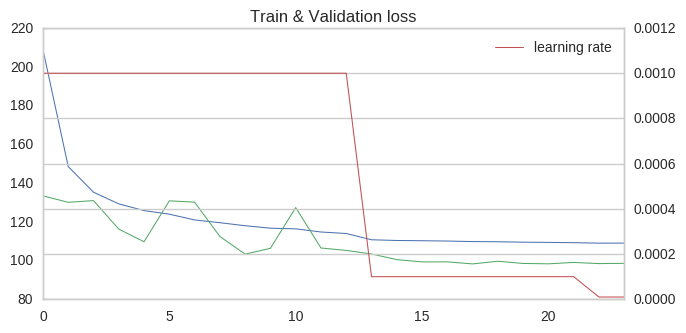

In [95]:
data_plot = loss_df.ix[:,:]
sns.set(style='whitegrid',)
sns.plt.figure(figsize=(7.5,3.5))

data_plot.loss.plot(label='train',lw=0.75)
data_plot.val_loss.plot(label='validation',lw=0.75)
data_plot.lr.plot(label='learning rate',secondary_y=True,lw=0.75)
plt.legend()
plt.title('Train & Validation loss');

In [196]:
np.random.seed(42)
samples = np.random.randint(0,25000,10)
original = train_x[samples]
predicted  = model.predict(original)
predicted = predicted.astype(np.uint8)

plt.figure(figsize=(10,5))

for column in range(1,6,1):
    
    image = original[column]
    image_predicted = predicted[column]
    
    plt.subplot(2,5,column)
    plt.imshow(image)
    plt.axis('off')
        
    plt.subplot(2,5,5+column)
    plt.imshow(image_predicted)
    plt.axis('off')
    
#plt.savefig('predictions_'+run+'.jpg',dpi=250)

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("input_1:0", shape=(?, 256, 256, 3), dtype=float32) is not an element of this graph.